# Cyclic Coordinate Descent for Logistic Regression with Lasso regularization

This notebook presents the implementation of Cyclic Coordinate Descent (CCD) algorithm for parameter 
estimation in regularized logistic regression with l1 (lasso) penalty and compares it with standard 
logistic regression model without regularization. 

TODO: Questions:

1. Keep all the function definitions in one separate section or in the relevant sections as it is right now. - In one section and add better docstrings, output must be there, could also add params
2. What is meant by *iteration* here: Likelihood function values and coefficient values depending on *iteration* - *Iteration* of the middle loop or the lambda parameter? - generally the inner (middle) loop, but it depends on us if we want to show outer or inner
3. How long should the methodology section be in the report. Should we explain what Log Reg is from ground up or just discuss the performance improvements? - short, just the optimizations, but the section in notebook can stay
4. Is it ok if we merge the comparison of LogRegCCD with Log Reg no reg and LogRegCCD with Log Reg L1 - yes, in general we should produce plots that show as much as possible
5. How to place legend on multiplots, only 1? - yes, only on the first graph is fine, but change the colors of the lines
6. Is creating a specific class for each real dataset ok?\ - yes as long as there is instruction of how to use a custom prepared dataset (how to use Dataset class basically)
7. How many n,p,d,g params to check? - what we have is bsaically fine, we could add more if we wish to. We should examine the case when n is low and d is high, and then check the effect of g
9. Can we compare our solution to glmnet? - yes
10. Can we change the margins in the report - yes, even the font, but in a reasonable way
11. If we need more consultations, we can contact prof on teams on Sunday, Monday, Tuesday

Discussion of the correctness:
1. Generate a dataset with some redundant varaibles and check whether they get set to 0
2. Compare with some ready implementation of ccg, compare the lambda values, coefficients paths
3. Set beta start, as a result of log reg without l1, then less itration wiht small lambdas

# Imports & Consts

In [1]:
import os
from scipy.io import arff
import numpy as np
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
)
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
import gc
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning


sns.set_theme(style="whitegrid", palette="cubehelix")
sns.set_context("notebook", font_scale=1.2)

In [2]:
CONST_DATASET_DIRECTORY_PATH = "./datasets"
CONST_RESULTS_DIRECTORY_PATH = "./results"

In [3]:
CONST_RESULTS_FILE_NAME = "results.pkl"

In [4]:
# Ensure reproducibility (More details in the README.md)
CONST_RANDOM_SEED = 42
np.random.seed(CONST_RANDOM_SEED)

# Classes & Functions

## Data preprocessing & Datasets

TODO: Find 4 datasets

In [ ]:
def load_datasets() -> List[dict[str, pd.DataFrame]]:
    """Load all ARFF datasets from the datasets folder and return them as a list of dictionaries containing names and dataframes.

    Returns
    -------
    List[dict[str, pd.DataFrame]]
        List of dictionaries where each dictionary contains:
        - 'name': str, name of the dataset
        - 'data': pd.DataFrame, the loaded dataset
    """
    datasets = []
    for file in os.listdir(CONST_DATASET_DIRECTORY_PATH):
        if file.endswith(".arff"):
            data = arff.loadarff(f"{CONST_DATASET_DIRECTORY_PATH}/{file}")
            df = pd.DataFrame(data[0])
            datasets.append({"name": file.strip(".arff"), "data": df})
    return datasets


def load_dataset(path: str) -> pd.DataFrame:
    """Load a dataset from a given path and return it as a pandas dataframe.

    Parameters
    ----------
    path : str
        Path to the ARFF dataset file.

    Returns
    -------
    pd.DataFrame
        The loaded dataset as a pandas DataFrame.
    """
    data = arff.loadarff(path)
    return pd.DataFrame(data[0])

In [ ]:
class Dataset:
    """Represents the dataset with the name, features, target, and preprocessing steps.
    Features and target are available as numpy arrays after preprocessing.
    """

    def __init__(
        self, name: str, df: pd.DataFrame, preprocessing_steps: List[callable] = None
    ):
        """Initialize a new dataset with a name, data, and preprocess the data resulting in two numpy arrays. X - features, and y - target.

        Parameters
        ----------
        name : str
            Name of the dataset
        df : pd.DataFrame
            Input dataframe containing features and target
        preprocessing_steps : List[callable], optional
            List of preprocessing functions to apply to features
        """
        self.name = name
        self.preprocessing_steps = preprocessing_steps

        self.X = df[df.columns[:-1]]
        self.y = df[df.columns[-1]]

        for step in self.preprocessing_steps:
            self.X = step(self.X)

        # Rest of the implementation remains the same
        self.X = self.X.to_numpy()
        self.class_names = self.y.unique()
        self.y = self.y.copy()
        indexes_0 = np.where(self.y == self.class_names[0])
        indexes_1 = np.where(self.y == self.class_names[1])
        self.y[indexes_0] = 0
        self.y[indexes_1] = 1
        self.y = self.y.to_numpy()

    def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        """Fill the missing values in the dataframe using the mean of the column strategy.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe with missing values

        Returns
        -------
        pd.DataFrame
            Dataframe with missing values filled with column means
        """
        return df.fillna(df.mean())

    def remove_colinear_features(
        df: pd.DataFrame, threshold: float = 0.8
    ) -> pd.DataFrame:
        """Remove features of a dataframe that are colinear.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe
        threshold : float, optional
            Correlation threshold for feature removal (default=0.8)

        Returns
        -------
        pd.DataFrame
            Dataframe with colinear features removed
        """
        corr_matrix = df.corr().abs()
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        to_drop = [
            column for column in upper_tri.columns if any(upper_tri[column] > threshold)
        ]
        return df.drop(columns=to_drop)

    def normalize(df: pd.DataFrame) -> pd.DataFrame:
        """Normalize the features of a dataframe based on Min-Max.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe to normalize

        Returns
        -------
        pd.DataFrame
            Normalized dataframe with values in range [0, 1]
        """
        return (df - df.min()) / (df.max() - df.min())


class APBreastKidney(Dataset):
    """APBreastKidney dataset.
    source: https://www.openml.org/search?type=data&sort=runs&id=1158&status=active
    """

    dataset_path = f"{CONST_DATASET_DIRECTORY_PATH}/AP_Breast_Kidney.arff"

    def __init__(self):
        """Initialize the APBreastKidney dataset"""
        data = load_dataset(APBreastKidney.dataset_path)
        super().__init__(
            "APBreastKidney",
            data,
            [
                Dataset.fill_missing_values,
                Dataset.remove_colinear_features,
                Dataset.normalize,
            ],
        )


class SyntheticDataset(Dataset):
    def __init__(self, p=0.5, n=1000, d=10, g=0.1):
        """Initialize the synthetic dataset with the given parameters.

        Parameters
        ----------
        p : float, optional
            Class prior probability (default=0.5)
        n : int, optional
            Number of samples (default=1000)
        d : int, optional
            Number of features/dimensions (default=10)
        g : float, optional
            Covariance matrix parameter (default=0.1)
        """
        y = np.random.binomial(1, p, n)
        X = np.zeros((n, d))

        X[y == 0] = np.random.multivariate_normal(
            np.zeros(d),
            np.array([[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]),
            sum(y == 0),
        )
        X[y == 1] = np.random.multivariate_normal(
            np.array([1 / (i + 1) for i in range(d)]),
            np.array([[np.pow(g, np.abs(i - j)) for i in range(d)] for j in range(d)]),
            sum(y == 1),
        )

        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data = pd.DataFrame(data)

        super().__init__(
            "SyntheticDataset",
            data,
            [
                Dataset.normalize,
            ],
        )

## LogRegCCD

Implementation of regularized Logistic Regression with Cyclic Coordinate Descent based on the [publication](https://www.jstatsoft.org/article/view/v033i01) (Chapter 3 is most relevant).

In [ ]:
def precision(y_true, y_pred):
    """Calculate precision score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Precision score in range [0, 1].
    """
    return precision_score(y_true, y_pred, zero_division=0.0)


def recall(y_true, y_pred):
    """Calculate recall score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Recall score in range [0, 1].
    """
    return recall_score(y_true, y_pred, zero_division=0.0)


def f1(y_true, y_pred):
    """Calculate F1 score while handling zero division.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        F1 score in range [0, 1].
    """
    return f1_score(y_true, y_pred, zero_division=0.0)


def balanced_accuracy(y_true, y_pred):
    """Calculate balanced accuracy score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Balanced accuracy score in range [0, 1].
    """
    return balanced_accuracy_score(y_true, y_pred)


def roc_auc(y_true, y_pred):
    """Calculate ROC AUC score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Target scores, can either be probability estimates, confidence values, or decisions.

    Returns
    -------
    float
        ROC AUC score in range [0, 1].
    """
    return roc_auc_score(y_true, y_pred)


def accuracy(y_true, y_pred):
    """Calculate accuracy score.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.

    Returns
    -------
    float
        Accuracy score in range [0, 1].
    """
    return accuracy_score(y_true, y_pred)

### LogRegCCD Algorithm

Logistic Regression is a machine learning method capable of binary classification. It predicts the probability of an outcome. Its steps are as follows:

Compute a linear combination of input features:

$$
z = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n = \mathbf{w}^T \mathbf{x} + b
$$

Where:
- $x$ denotes input feature vector, where $x_1,...,x_n$ are the elements of that vector
- $w$ denotes model weights vector 
- $b$ is the bias term  

The output $z$ is then provided to the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

The output in range [0,1] denotes the probability that given feature vector $x$ belongs to the positive class.

Prediction rule is based on the output of the sigmoid function, if it's larger than 0.5 we assign to class 1, otherwise assign to class 0.

To fit the model to the training data. One needs to minimize the loss function, in this case Binary Cross-Entropy:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right]
$$

Where:
- $m$ denotes the number of training examples  
- $y^{(i)}$ is the class label 
- $\hat{y}^{(i)}$ is the predicted probability  


The weights of the model need to be optimized to find the proper fit, this can be achieved by standard gradient descent:

$$
w_j := w_j - \alpha \frac{\partial \mathcal{L}}{\partial w_j}
$$

$$
b := b - \alpha \frac{\partial \mathcal{L}}{\partial b}
$$

Where:
- $\alpha$ is the learning rate, the higher the value the more aggressive weight updates  
- $\frac{\partial \mathcal{L}}{\partial w_j}$ is a gradient with respect to weight $w_j$


Lasso Regulaization is used to prevent overfitting, when the trained model can predict samples from the training set very well but struggles on the test set.

Then the loss function becomes:

$$
\mathcal{L}_{\text{lasso}} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \hat{y}^{(i)} + \left(1 - y^{(i)}\right) \log \left(1 - \hat{y}^{(i)}\right) \right] + \lambda \sum_{j=1}^{n} |w_j|
$$

Where:
- $m$  is the number of training samples  
- $y^{(i)}$ is the class label
- $\hat{y}^{(i)}$ is the predicted probability 
- $\lambda$ denotes regularization strength 

In essence during the training process, the model will also minizem the absolute sum of the coefficients in addition to the loss function

Now, to use the Cyclic Coordinate Descent instead of the standard Gradient Descent one needs to minimize the $\mathcal{L}_{\text{lasso}}$ using a different algorithm for updating model weights.

However the authors of the [publication](https://www.jstatsoft.org/article/view/v033i01) present a more sophisticated approach with certain optimizations so let us focus on them first.

First, the Logistic Regression log-likelihood is approximated with a quadratic approximation:

$$
\ell_Q(\beta_0, \beta) = -\frac{1}{2N} \sum_{i=1}^{N} w_i (z_i - \beta_0 - x_i^T \beta)^2 + C
$$

That converts the problem into a penalized weighted least squares.

The authors also use a regularization path that starts from largest $\lambda$ where $\beta = 0$ and decreases $\lambda$ gradually, using previous solutions as warm starts.

Instead of computing gradients from scratch with each iteration, the authors propose to use covariance updates:

$$
\sum_{i=1}^{N} x_{ij} r_i = \langle x_j, y \rangle - \sum_{k: \beta_k \neq 0} \langle x_j, x_k \rangle \beta_k
$$

For each feature $j$, the optimization problem simplifies to:

$$
\min_{\beta_j} \left[ \frac{1}{2} \sum_{i=1}^{N} w_i \left( z_i - \beta_0 - \sum_{k \neq j} x_{ik} \beta_k - x_{ij} \beta_j \right)^2 + \lambda |\beta_j| \right]
$$

To update the weights using CCD one needs to (for weight j):
1. Compute partial residuals (excluding $\beta_j$):

   $$
   r_i = z_i - (\beta_0 + \sum_{k \neq j} x_{ik} \beta_k)
   $$

2. Compute the gradient component $\rho_j$:

   $$
   \rho_j = \sum_{i=1}^{N} w_i x_{ij} r_i
   $$

3. Apply soft-thresholding for L1 regularization:

   $$
   \beta_j = \frac{S(\rho_j, \lambda)}{\sum_{i=1}^{N} w_i x_{ij}^2}
   $$

   where the soft-thresholding operator is:

   $$
   S(z, \lambda) = \text{sign}(z) \cdot \max(|z| - \lambda, 0)
   $$

And then $\beta_0$ that is not regularized:
$$
\beta_0 = \frac{\sum_{i=1}^{N} w_i (z_i - x_i^T \beta)}{\sum_{i=1}^{N} w_i}
$$


From a high level overview the presented algorithm consists of:

1. Outer Loop:
   - Decrease $\lambda$ along a regularization path.

2. Middle Loop:
   - Update the quadratic approximation using the current $(\beta_0, \beta)$.

3. Inner Loop:
   - Perform coordinate descent on the penalized weighted least squares problem.



In [ ]:
class LogRegCCD:
    """Logistic Regression with Coordinate Cyclic Descent and Lasso Regularization."""

    def __init__(self) -> None:
        """Initialize the LogRegCCD model."""
        self.lambda_ = None

        self.beta = None
        self.beta_0 = None
        self.weights = []

        # We have noticed that after a certain point, model's accuracy starts to decrease
        # Therefore, we add the possibility to perform early stopping based on the validation set

        self.best_lambda = None
        self.best_beta = None
        self.best_beta_0 = None

        # Keep track of weights for each iteration for each lambda for later analysis

        self.metrics = {}

    def fit(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray = None,
        y_valid: np.ndarray = None,
        measure: callable = None,
        regularization_path_lambda_sequence: np.ndarray = np.logspace(
            1, -3, 50
        ),  # The model is quite sensitive to the lambda values, high lambda values may result in all coefficients being zero
        maximum_iterations: int = 1000,
        convergance_threshold: float = 1e-05,
        minimum: float = 1e-05,
        track_likelihood_and_weights: bool = False,
    ) -> None:
        """Fit the Logsitic Regression model on provided training features and labels."""

        _, number_of_features = X_train.shape
        self.beta = np.zeros(number_of_features)  # Initialize coefficients
        self.beta_0 = 0  # Initialize intercept

        # Track the likelihood and weights for each iteration
        self.metrics = {
            lambda_: {
                "likelihood": [],
                "beta": [],
                "intercept": [],
                "iteration": [],
                "metric": 0,
            }
            for lambda_ in regularization_path_lambda_sequence
        }

        for (
            lambda_
        ) in (
            regularization_path_lambda_sequence
        ):  # Outer Loop: Decrease $ \lambda $ along a regularization path.

            self.lambda_ = lambda_

            if track_likelihood_and_weights == True:
                self.metrics[lambda_]["likelihood"].append(
                    self._get_log_likelihood(X_train, y_train)
                )
                self.metrics[lambda_]["beta"].append(self.beta.copy())
                self.metrics[lambda_]["intercept"].append(self.beta_0)
                self.metrics[lambda_]["iteration"].append(0)

            for iteration_index in range(
                maximum_iterations
            ):  # Middle Loop: Update the quadratic approximation using the current $ (\beta_0, \beta) $.

                previous_beta = self.beta.copy()
                previous_beta_0 = self.beta_0

                # Linear Predictions and Probabilities

                linear_prediction = self.beta_0 + np.dot(X_train, self.beta)
                probabilities = self.sigmoid(linear_prediction)

                # Weights and Working Response

                weights = np.maximum(minimum, probabilities * (1 - probabilities))
                working_response = linear_prediction + np.divide(
                    y_train - probabilities, weights, where=weights != 0
                )

                # Update the intercept \beta_0

                self.beta_0 = np.divide(
                    np.sum(weights * (working_response - np.dot(X_train, self.beta))),
                    np.sum(weights),
                    where=np.sum(weights) != 0,
                )

                # Coordinate Descent for each feature

                for feature_index in range(
                    number_of_features
                ):  # Inner Loop: Update the coefficients $ \beta $

                    # Compute the partial residual

                    partial_residual = (
                        working_response
                        - self.beta_0
                        - np.dot(
                            X_train[:, np.arange(number_of_features) != feature_index],
                            self.beta[np.arange(number_of_features) != feature_index],
                        )
                    )

                    # Compute the coordinate-wise derivative

                    coordinate_derivative = np.dot(
                        weights * X_train[:, feature_index], partial_residual
                    )

                    # Soft-thresholding

                    denominator = np.sum(weights * X_train[:, feature_index] ** 2)
                    self.beta[feature_index] = np.divide(
                        self.soft_thresholding(coordinate_derivative, lambda_),
                        denominator,
                        where=denominator != 0,
                    )

                # Track the likelihood and weights for each iteration
                if track_likelihood_and_weights == True:
                    self.metrics[lambda_]["likelihood"].append(
                        self._get_log_likelihood(X_train, y_train)
                    )
                    self.metrics[lambda_]["beta"].append(self.beta.copy())
                    self.metrics[lambda_]["intercept"].append(self.beta_0)
                    self.metrics[lambda_]["iteration"].append(iteration_index + 1)

                # Check for convergence

                if (
                    np.linalg.norm(self.beta - previous_beta) < convergance_threshold
                    and np.abs(self.beta_0 - previous_beta_0) < convergance_threshold
                ):
                    break

            self.weights.append(
                {
                    "lambda": lambda_,
                    "weights": self.beta.copy(),
                    "intercept": self.beta_0,
                }
            )

            # Calculate the metric on the validation set
            if X_valid is not None and y_valid is not None and measure is not None:
                self.metrics[lambda_]["metric"] = self.validate(
                    X_valid, y_valid, measure, best_lambda=False
                )

        # Find the best lambda based on the validation set
        if X_valid is not None and y_valid is not None and measure is not None:
            self.best_lambda = max(
                self.metrics, key=lambda l: self.metrics[l]["metric"]
            )

            best_model = [
                model for model in self.weights if model["lambda"] == self.best_lambda
            ][0]

            self.best_beta, self.best_beta_0 = (
                best_model["weights"],
                best_model["intercept"],
            )

    def _get_log_likelihood(
        self, X: np.ndarray, y: np.ndarray, best_lambda: bool = False
    ) -> float:
        """Compute the log likelihood of the model."""

        if best_lambda is True:
            weights = self.best_beta
            intercept = self.best_beta_0
            lambda_ = self.best_lambda
        else:
            weights = self.beta
            intercept = self.beta_0
            lambda_ = self.lambda_
        # y = beta_0 + beta_1 * x_1 + beta_2 * x_2 + ... + beta_n * x_n
        linear_prediction = intercept + np.dot(X, weights)

        # According to the logsitic regression log likelihood formula, given in the explanation above
        return np.sum(
            y * linear_prediction - np.log(1 + np.exp(linear_prediction))
        ) - lambda_ * np.sum(np.abs(weights))

    def validate(
        self,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        measure: callable,
        best_lambda: bool = True,
    ) -> float:
        """Compute the provided measure based on the validation features and labels."""
        if measure.__name__ == roc_auc.__name__:
            return measure(y_valid, self.predict_proba(X_valid, best_lambda))
        return measure(y_valid, self.predict(X_valid, best_lambda))

    def predict(
        self, X_test: np.ndarray, best_lambda: bool = True, threshold: float = 0.5
    ) -> np.ndarray:
        """Predict the classes for the test features."""
        probability = self.predict_proba(X_test, best_lambda)
        if probability is None:
            return None
        return probability > threshold

    def predict_proba(self, X_test: np.ndarray, best_lambda: bool = True) -> np.ndarray:
        """Predict the probabilities of the classes for the test features."""
        if best_lambda is True and (
            self.best_beta is None
            or self.best_beta_0 is None
            or self.best_lambda is None
        ):
            print(
                "Please fit the model first with validation set if you wish to use best lambda parameter or set the best_lambda argument to False."
            )
            return None
        return (
            self.sigmoid(self.best_beta_0 + np.dot(X_test, self.best_beta))
            if best_lambda
            else self.sigmoid(self.beta_0 + np.dot(X_test, self.beta))
        )

    def plot(
        self, measure: callable, X_test: np.ndarray, y_test: np.ndarray, figsize=(6, 4)
    ) -> Figure:
        """Plot the evalueation measure over different values of lambda."""

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")
        coefficients_df = coefficients_df.sort_index(ascending=False)

        measures = []
        for w in self.weights:
            self.beta = w["weights"]
            self.beta_0 = w["intercept"]
            measures.append(measure(y_test, self.predict(X_test, best_lambda=False)))

        plt.figure(figsize=figsize)
        plt.plot(coefficients_df.index, measures)
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Measure Value")
        plt.title(f"Model Performance ({measure.__name__}) vs Lambda")
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()
        return fig

    def plot_coefficients(self, figsize=(6, 4)) -> Figure:
        """Plot the coefficients of the model over different values of lambda."""
        # TODO: Also are we sure that by lambda we mean the regularization path parameter?

        coefficients_df = pd.DataFrame(self.weights)
        coefficients_df = coefficients_df.set_index("lambda")
        coefficients_df = coefficients_df.sort_index(ascending=False)

        weights_df = pd.DataFrame(
            coefficients_df["weights"].tolist(),
            index=coefficients_df.index,
            columns=[f"beta_{i}" for i in range(len(self.beta))],
        )

        plt.figure(figsize=figsize)
        for col in weights_df.columns:
            plt.plot(weights_df.index, weights_df[col], label=col)

        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()
        return fig

    def plot_validation_scores(self, figsize=(6, 4)) -> Figure:
        """Plot the validation scores over different values of lambda."""
        plt.figure(figsize=figsize)
        xAxis = list(self.metrics.keys())
        yAxis = [self.metrics[lambda_]["metric"] for lambda_ in xAxis]
        plt.plot(xAxis, yAxis)
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Validation Score")
        plt.title("Validation Score vs Lambda")
        plt.grid(True)
        plt.gca().invert_xaxis()
        fig = plt.gcf()
        plt.show()
        return fig

    # Helper functions

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Returns the sigmoid function result."""
        return 1 / (1 + np.exp(-z))

    def soft_thresholding(self, z: float, lambda_: float) -> float:
        """Applies soft-thresholding for L1"""
        return np.sign(z) * np.maximum(np.abs(z) - lambda_, 0)

## Performing Experiments

In [ ]:
def perform_experiment(
    test_case: dict, results: List[dict], seeds: List[int], metrics: List[callable]
) -> None:
    """Perform an experiment on the provided test case, compute the provided metrics and store the results.

    Parameters
    ----------
    test_case : dict
        Dictionary containing experiment parameters with keys 'p', 'n', 'd', 'g'.
    results : List[dict]
        List to store experiment results for different models and metrics.
    seeds : List[int]
        List of random seeds for reproducibility.
    metrics : List[callable]
        List of metric functions to evaluate model performance.

    Returns
    -------
    None
        Results are stored in the provided results list.

    """

    for seed in seeds:
        np.random.seed(seed)
        try:
            synthetic_dataset = SyntheticDataset(
                test_case["p"], test_case["n"], test_case["d"], test_case["g"]
            )

            X_train, X_temp, y_train, y_temp = train_test_split(
                synthetic_dataset.X,
                synthetic_dataset.y,
                test_size=0.4,
                random_state=CONST_RANDOM_SEED,
            )
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp,
                y_temp,
                test_size=0.5,
                random_state=CONST_RANDOM_SEED,
            )

            log_reg_ccd = LogRegCCD()
            log_reg_ccd.fit(
                X_train,
                y_train,
                X_valid=X_val,
                y_valid=y_val,
                measure=accuracy_score,
            )

            log_reg_ccd_weights = log_reg_ccd.weights
            log_reg_ccd_best_lambda = log_reg_ccd.best_lambda
            log_reg_ccd_best_beta = log_reg_ccd.best_beta
            log_reg_ccd_best_beta_0 = log_reg_ccd.best_beta_0
            log_reg_ccd_weights.append(
                {
                    "lambda": log_reg_ccd_best_lambda,
                    "weights": log_reg_ccd_best_beta,
                    "intercept": log_reg_ccd_best_beta_0,
                }
            )

            for metric in metrics:

                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": log_reg_ccd.validate(
                            X_test, y_test, metric, best_lambda=True
                        ),
                        "metric_name": metric.__name__,
                        "model": "LogRegCCD",
                        "seed": seed,
                        "weights": log_reg_ccd_weights,
                    }
                )

            log_sklearn = LogisticRegression(penalty=None)
            log_sklearn.fit(X_train, y_train)
            for metric in metrics:
                if metric.__name__ == roc_auc.__name__:
                    metric_value = metric(
                        y_test, log_sklearn.predict_proba(X_test)[:, 1]
                    )
                metric_value = metric(y_test, log_sklearn.predict(X_test))
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": metric_value,
                        "metric_name": metric.__name__,
                        "model": "LogRegSklearn",
                        "seed": seed,
                        "weights": {
                            "weights": log_sklearn.coef_,
                            "intercept": log_sklearn.intercept_,
                        },
                    }
                )
            log_sklearn_l1 = LogisticRegression(penalty="l1", solver="liblinear")
            log_sklearn_l1.fit(X_train, y_train)
            for metric in metrics:
                metric_value = metric(y_test, log_sklearn_l1.predict(X_test))
                results.append(
                    {
                        "p": test_case["p"],
                        "n": test_case["n"],
                        "d": test_case["d"],
                        "g": test_case["g"],
                        "metric_value": metric_value,
                        "metric_name": metric.__name__,
                        "model": "LogRegSklearnL1",
                        "seed": seed,
                        "weights": {
                            "weights": log_sklearn_l1.coef_,
                            "intercept": log_sklearn_l1.intercept_,
                        },
                    }
                )
        except Exception as e:
            print(f"An error occured during the experiment: {e}")
            print(f"Test case: {test_case}")

        finally:
            local_vars = list(locals().keys())
            if "synthetic_dataset" in local_vars:
                del synthetic_dataset
            if "log_reg_ccd" in local_vars:
                del log_reg_ccd
            if "log_sklearn" in local_vars:
                del log_sklearn
            if "X_train" in local_vars:
                del X_train
            if "X_test" in local_vars:
                del X_test
            if "y_train" in local_vars:
                del y_train
            if "y_test" in local_vars:
                del y_test


def create_test_cases(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters
    ----------
    parameters : dict
        A dictionary with the parameter name as the key and a list of values as the value.
        It must contain the keys 'p', 'n', 'd', and 'g'.

    Returns
    -------
    List[dict]
        A list of dictionaries, where each dictionary represents a test case with
        one parameter varied while others are kept at their first value.
    """
    test_values = []
    for param_name, param_values in parameters.items():
        for value in param_values:
            test_case = {
                "p": parameters["p"][0],
                "n": parameters["n"][0],
                "d": parameters["d"][0],
                "g": parameters["g"][0],
            }
            test_case[param_name] = value
            test_values.append(test_case)
    return test_values


def create_test_cases_all_combinations(parameters: dict) -> List[dict]:
    """Create test cases for the experiment based on the provided parameters.

    Parameters
    ----------
    parameters : dict
        A dictionary with the parameter name as the key and a list of values as the value.
        It must contain the keys 'p', 'n', 'd', and 'g'.

    Returns
    -------
    List[dict]
        A list of dictionaries, where each dictionary represents a test case with all possible
        combinations of the parameter values.
    """
    test_values = []
    for p in parameters["p"]:
        for n in parameters["n"]:
            for d in parameters["d"]:
                for g in parameters["g"]:
                    test_case = {
                        "p": p,
                        "n": n,
                        "d": d,
                        "g": g,
                    }
                    test_values.append(test_case)
    return test_values

## Analyzing the results

In [ ]:
def plot_synthetic_parameter_facet_grid_boxplot(
    results_df: pd.DataFrame,
    parameters: List = ["p", "n", "d", "g"],
    file_name: str = "parameter_facet_grid",
    metrics_of_interest: List = [roc_auc.__name__, balanced_accuracy.__name__],
) -> None:
    """Plot the results of the synthetic dataset experiment in a facet grid.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', and 'model'
    parameters : list, optional
        The parameters to plot in the facet grid, by default ["p", "n", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'parameter_facet_grid'
    metrics_of_interest : list, optional
        Metrics to include in the plot, by default [roc_auc.__name__, balanced_accuracy.__name__]. The metrics must be present in the results_df.

    Returns
    -------
    None
        Displays and saves the facet grid plot
    """

    _, axes = plt.subplots(len(metrics_of_interest), len(parameters), figsize=(20, 8))

    for i, metric in enumerate(metrics_of_interest):
        for j, param in enumerate(parameters):
            metric_data = results_df[results_df["metric_name"] == metric]

            sns.boxplot(
                data=metric_data, x=param, y="metric_value", hue="model", ax=axes[i, j]
            )

            axes[i, j].set_title(f"{metric} vs {param}")
            if j == 0:
                axes[i, j].set_ylabel(metric)
            else:
                axes[i, j].set_ylabel("")

            if j != len(parameters) - 1 or i != 0:
                axes[i, j].get_legend().remove()
            else:
                axes[i, j].legend(loc="upper center")

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()


def plot_synthetic_parameter_facet_grid_mean(
    results_df: pd.DataFrame,
    parameters: List = ["p", "n", "d", "g"],
    file_name: str = "parameter_facet_grid",
    metrics_of_interest: List = [roc_auc.__name__, balanced_accuracy.__name__],
) -> None:
    """Plot the results of the synthetic dataset experiment in a facet grid. The plot shows the mean of the metrics for each model.

    Parameters
    ----------
    results_df : pd.DataFrame
        The results dataframe containing columns 'p', 'n', 'd', 'g', 'metric_name', 'metric_value', and 'model'
    parameters : list, optional
        The parameters to plot in the facet grid, by default ["p", "n", "d", "g"]
    file_name : str, optional
        Name of the output plot file, by default 'parameter_facet_grid'
    metrics_of_interest : list, optional
        Metrics to include in the plot, by default [roc_auc.__name__, balanced_accuracy.__name__]. The metrics must be present in the results_df.

    Returns
    -------
    None
        Displays and saves the facet grid plot
    """

    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for metric_idx, metric in enumerate(metrics_of_interest):
        for param_idx, param in enumerate(parameters):
            subset = results_df[results_df["metric_name"] == metric]
            param_df = (
                subset.groupby([param, "model"])["metric_value"].mean().reset_index()
            )

            sns.lineplot(
                data=param_df,
                x=param,
                y="metric_value",
                hue="model",
                style="model",
                markers=True,
                dashes=True,
                ax=axs[metric_idx, param_idx],
            )

            axs[metric_idx, param_idx].set_title(f"Effect of {param} on {metric}")
            if param_idx == 0:
                axs[metric_idx, param_idx].set_ylabel("Mean " + metric)
            else:
                axs[metric_idx, param_idx].set_ylabel("")

            if (metric_idx == 0 and param_idx > 0) or metric_idx == 1:
                axs[metric_idx, param_idx].get_legend().remove()

    plt.tight_layout()
    plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/{file_name}.png")
    plt.show()

# Experiments

## Real Data

In [7]:
%%time
# Keep in mind removing colinear features on a dataset with couple thousands of them is relatively time consuming

# datasets = [APBreastKidney()]

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time

# Alternatively, load all ARFF datasets from the datasets folder
# As a result you will obtain a list Datasets objects

# datasets = load_datasets()

# preprocessing_steps = [
#     Dataset.fill_missing_values,
#     Dataset.remove_colinear_features,
#     Dataset.normalize,
# ]

# for i in range(len(datasets)):
#     datasets[i] = Dataset(datasets[i]["name"], datasets[i]["data"], preprocessing_steps)

CPU times: total: 0 ns
Wall time: 0 ns


## Effect of parameters n, p, d, g on the performance of LogisticRegression and LogRegCCD on synthetic data based on ROC AUC and Balanced Accuracy (threshold 0.5).

Including comparison with ready implementation of logistic regression with L1 penalty

TODO: Cleanup this section, add conclusions

### Generate parameters

In [ ]:
# parameters = {
#     "p": [0.5, 0.3, 0.4, 0.6, 0.7, 0.8],
#     "n": [2000, 5000, 10000],
#     "d": [10, 2, 4, 6, 20, 50],
#     "g": [0.3, 0.1, 0.5, 0.7, 0.9],
# }


# Create the test cases such that the first value of each parameter (except one) is held constant and the other parameters are varied
# test_cases = create_test_cases(parameters)


parameters = {
    "p": [0.3, 0.4, 0.5, 0.6, 0.7],
    "n": [1000, 1500, 2000],
    "d": [2, 5, 10, 30],
    "g": [0.1, 0.3, 0.5, 0.7, 0.9],
}


# Create all possible combinations of the parameters
test_cases = create_test_cases_all_combinations(parameters)

### Calcuate ROC AUC and Balanced Accuracy on the synthetic datasets for LogRegCCD, Logistic Regression, and Logistic Regression with L1

In [13]:
%%time

# TODO: Performance and Comparison according to the Project Task

# Ignoring the convergence warning for output clarity, this information is not crucial for the experiment
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# I think it is not needed to check every combination, if we just set all other parameters to constant and loop over current paramters
# it should be enough to examine its effects on the model performance

results = []
seeds = [
    CONST_RANDOM_SEED,
    CONST_RANDOM_SEED + 10,
    CONST_RANDOM_SEED + 20,
    CONST_RANDOM_SEED + 30,
    CONST_RANDOM_SEED + 40,
]

metrics = [
    accuracy,
    precision,
    recall,
    f1,
    roc_auc,
    balanced_accuracy,
]
no_of_test_cases = len(test_cases)

for i, test_case in enumerate(test_cases):
    print(f"Progress: {i}/{no_of_test_cases}", end="\r")
    perform_experiment(test_case, results, seeds, metrics)

CPU times: total: 1h 19min 12s
Wall time: 2h 3min 44s


### Save the results to a pickle file and free memory

In [14]:
results_df = pd.DataFrame(results)
results_df.to_pickle(f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}")

In [15]:
del results_df
del results
gc.collect()

0

### Load the results from the pickle file

*The reason why we load the results here right after saving is so that they can easily be analyzed/recreated without necessarily performing the experiments again*

In [16]:
results_df = pd.read_pickle(f"{CONST_RESULTS_DIRECTORY_PATH}/{CONST_RESULTS_FILE_NAME}")

### Plots depicting comparison of models in regards to the synthetic dataset

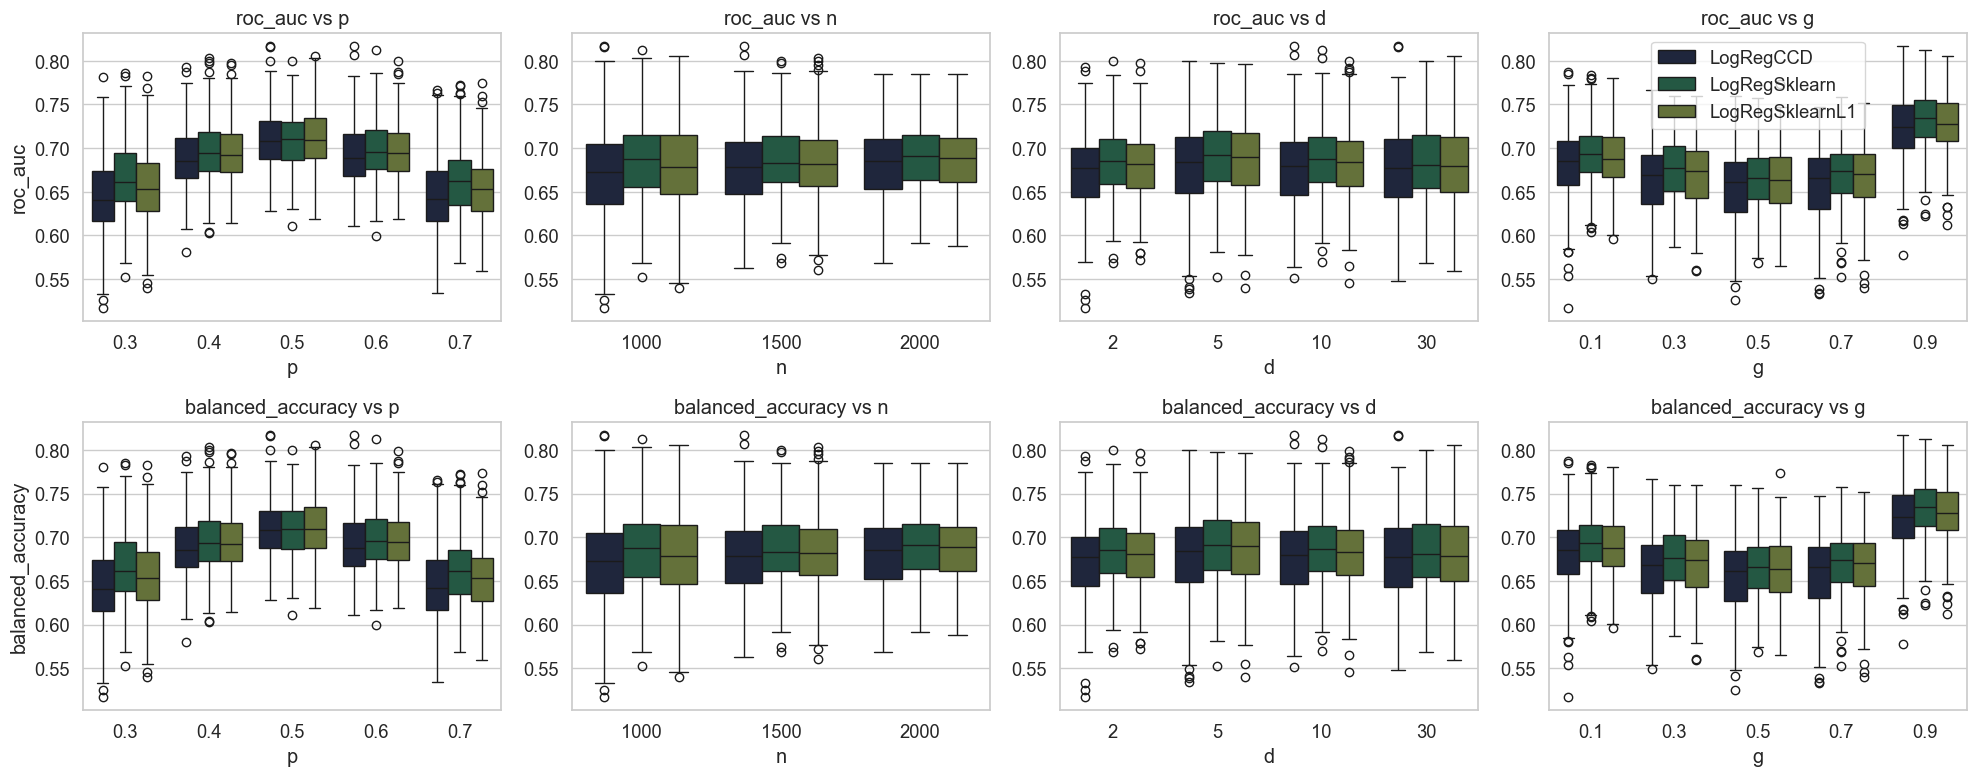

In [ ]:
# Plot the results of the synthetic dataset experiment in a facet grid. Examine the effects of the parameters on the model performance
plot_synthetic_parameter_facet_grid_boxplot(results_df)

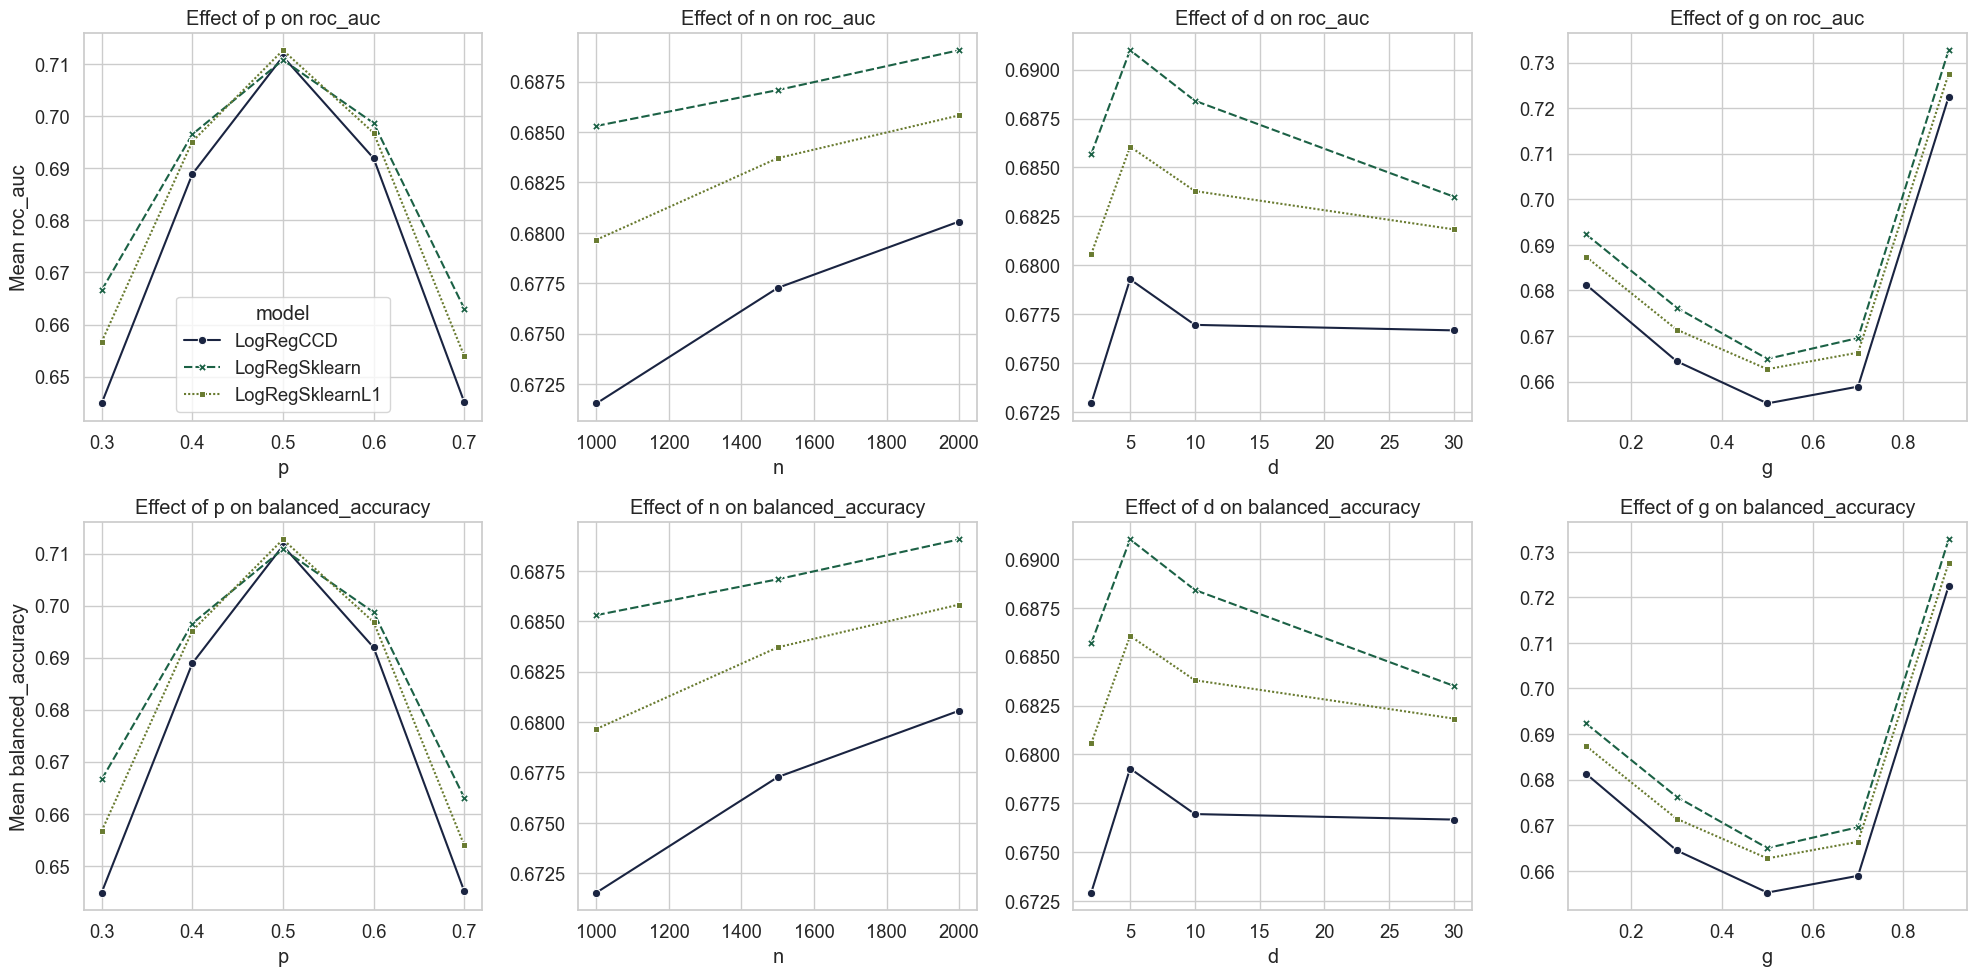

In [ ]:
# Plot the results of the synthetic dataset experiment in a facet grid. Examine the effects of the parameters on the average model performance
plot_synthetic_parameter_facet_grid_mean(results_df)

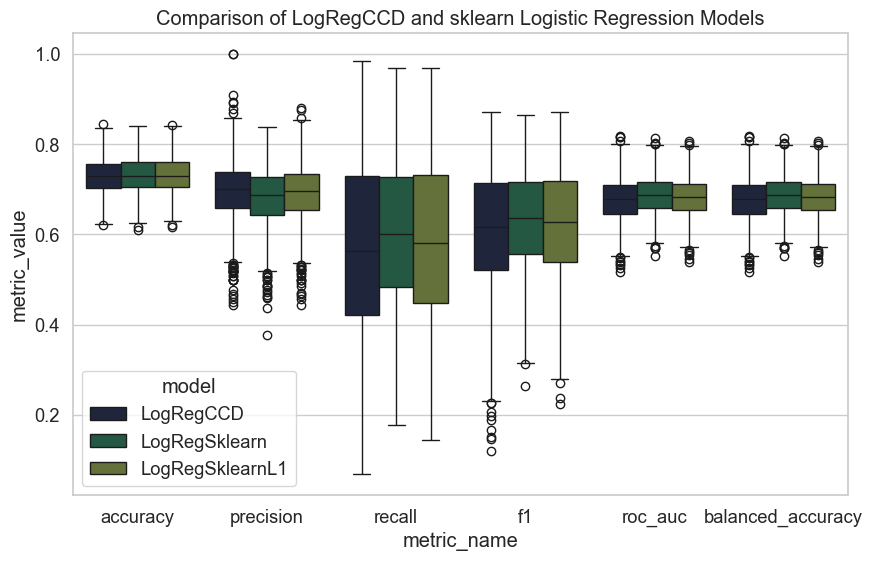

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=results_df,
    x="metric_name",
    y="metric_value",
    hue="model",
)
plt.title(f"Comparison of LogRegCCD and sklearn Logistic Regression Models")
plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/comparison-synthetic-dataset.png")
plt.show()

## The performance of the two methods on real datasets using ROC AUC, Recall-Precision AUC, F-measure and Balanced Accuracy as the evaluation measures

TODO

In [24]:
# TODO: Just iterate over the loaded real Datasets and test LogRegCCD, LogisticRegression and LogisticRegression with L1 regularization on them.

## Coefficient values obtained in these two methods

TODO: Cleanup this section. Add some conclusions

TODO: Add similar plots for the real datasets

In [28]:
# group by n.p.d.g and seed

grouped_df = results_df[results_df["metric_name"] == accuracy.__name__].groupby(
    ["n", "p", "d", "g", "seed"]
)

differences = []

# iterate over the grouped dataframe

for group, data in grouped_df:

    # get the weights for each model

    logRegCCDWeights = data[data["model"] == "LogRegCCD"]["weights"].to_numpy()[0][-1][
        "weights"
    ]
    logRegSklearnWeights = data[data["model"] == "LogRegSklearn"]["weights"].to_numpy()[
        0
    ]["weights"][0]
    logRegSklearnL1Weights = data[data["model"] == "LogRegSklearnL1"][
        "weights"
    ].to_numpy()[0]["weights"][0]

    logRegCCDIntercept = data[data["model"] == "LogRegCCD"]["weights"].to_numpy()[0][
        -1
    ]["intercept"]
    logRegSklearnIntercept = data[data["model"] == "LogRegSklearn"][
        "weights"
    ].to_numpy()[0]["intercept"][0]
    logRegSklearnL1Intercept = data[data["model"] == "LogRegSklearnL1"][
        "weights"
    ].to_numpy()[0]["intercept"][0]

    # calculate the difference between the weights of LogRegCCD and LogRegSklearn

    diffCCDvsSklearn = logRegCCDWeights - logRegSklearnWeights

    diffInterceptCCDvsSklearn = logRegCCDIntercept - logRegSklearnIntercept

    # calculate the difference between the weights of LogRegCCD and LogRegSklearnL1

    diffCCDvsSklearnL1 = logRegCCDWeights - logRegSklearnL1Weights

    diffInterceptCCDvsSklearnL1 = logRegCCDIntercept - logRegSklearnL1Intercept

    # calculate the difference between the weights of LogRegSklearn and LogRegSklearnL1

    diffSklearnvsSklearnL1 = logRegSklearnWeights - logRegSklearnL1Weights

    diffInterceptSklearnvsSklearnL1 = logRegSklearnIntercept - logRegSklearnL1Intercept

    # save the differences

    differences.append(
        {
            "n": group[0],
            "p": group[1],
            "d": group[2],
            "g": group[3],
            "seed": group[4],
            "diffCCDvsSklearn": diffCCDvsSklearn,
            "diffCCDvsSklearnL1": diffCCDvsSklearnL1,
            "diffSklearnvsSklearnL1": diffSklearnvsSklearnL1,
            "diffInterceptCCDvsSklearn": diffInterceptCCDvsSklearn,
            "diffInterceptCCDvsSklearnL1": diffInterceptCCDvsSklearnL1,
            "diffInterceptSklearnvsSklearnL1": diffInterceptSklearnvsSklearnL1,
        }
    )


differences_df = pd.DataFrame(differences)

# Calculate the mean differences

differences_df["avg_diff_CCD_Sklearn"] = differences_df["diffCCDvsSklearn"].apply(
    lambda x: np.mean(np.abs(x))
)
differences_df["avg_diff_CCD_SklearnL1"] = differences_df["diffCCDvsSklearnL1"].apply(
    lambda x: np.mean(np.abs(x))
)
differences_df["avg_diff_Sklearn_SklearnL1"] = differences_df[
    "diffSklearnvsSklearnL1"
].apply(lambda x: np.mean(np.abs(x)))

differences_df["avg_diff_Intercept_CCD_Sklearn"] = differences_df[
    "diffInterceptCCDvsSklearn"
].apply(lambda x: np.mean(np.abs(x)))

differences_df["avg_diff_Intercept_CCD_SklearnL1"] = differences_df[
    "diffInterceptCCDvsSklearnL1"
].apply(lambda x: np.mean(np.abs(x)))

differences_df["avg_diff_Intercept_Sklearn_SklearnL1"] = differences_df[
    "diffInterceptSklearnvsSklearnL1"
].apply(lambda x: np.mean(np.abs(x)))

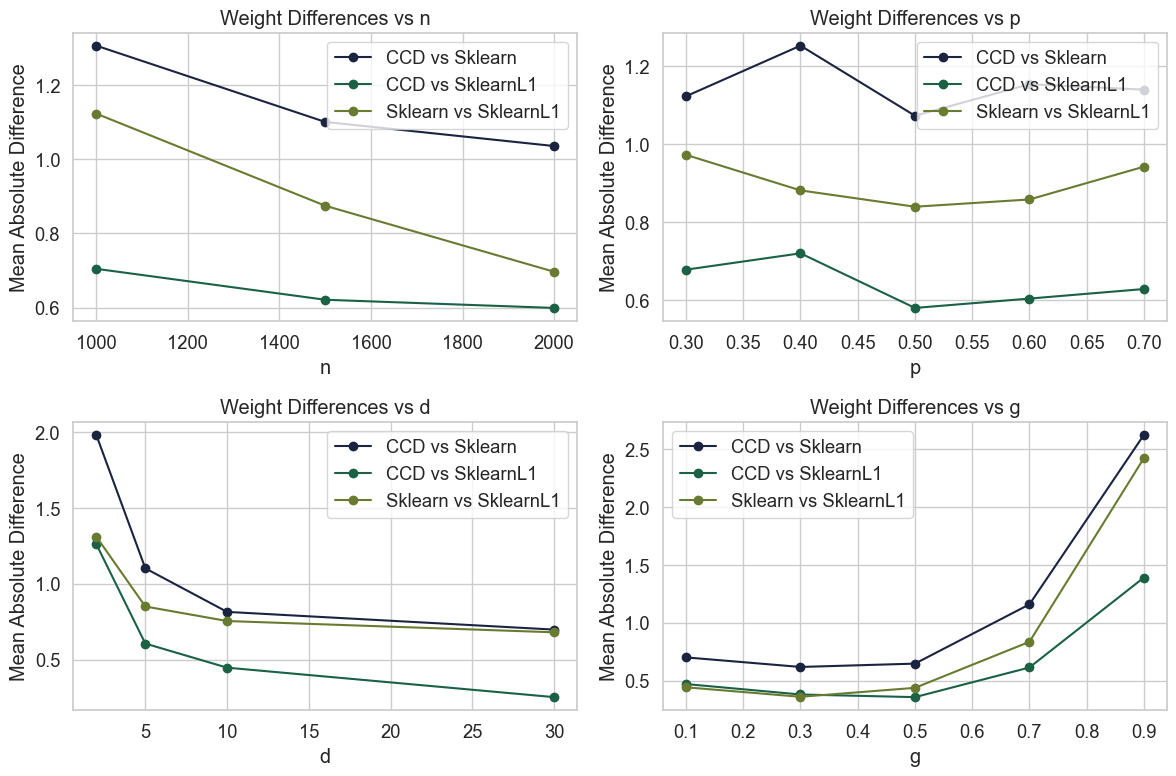

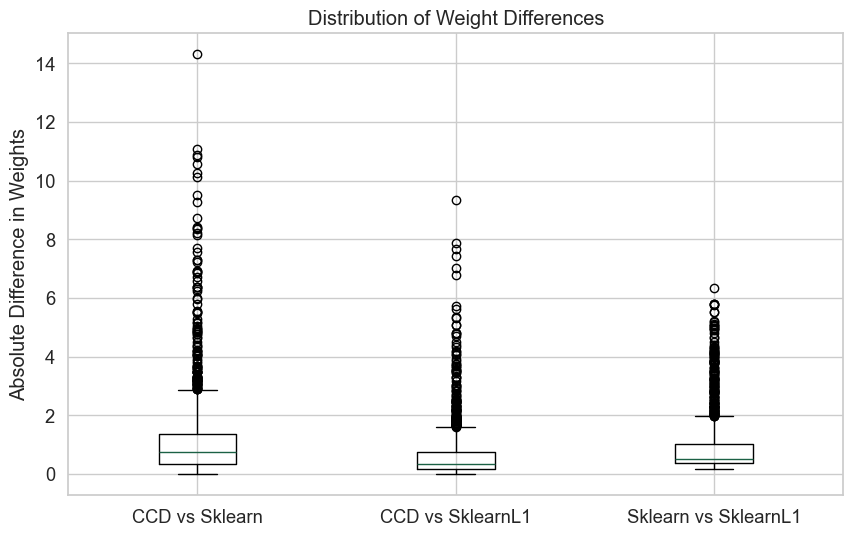

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
parameters = ["n", "p", "d", "g"]

for i, param in enumerate(parameters):
    row = i // 2
    col = i % 2

    mean_diffs = differences_df.groupby(param)[
        ["avg_diff_CCD_Sklearn", "avg_diff_CCD_SklearnL1", "avg_diff_Sklearn_SklearnL1"]
    ].mean()

    mean_diffs.plot(marker="o", ax=axes[row, col])
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel("Mean Absolute Difference")
    axes[row, col].set_title(f"Weight Differences vs {param}")
    axes[row, col].grid(True)
    axes[row, col].legend(
        ["CCD vs Sklearn", "CCD vs SklearnL1", "Sklearn vs SklearnL1"]
    )

plt.tight_layout()
plt.savefig(f"{CONST_RESULTS_DIRECTORY_PATH}/weight_differences_synthetic_dataset.png")
plt.show()

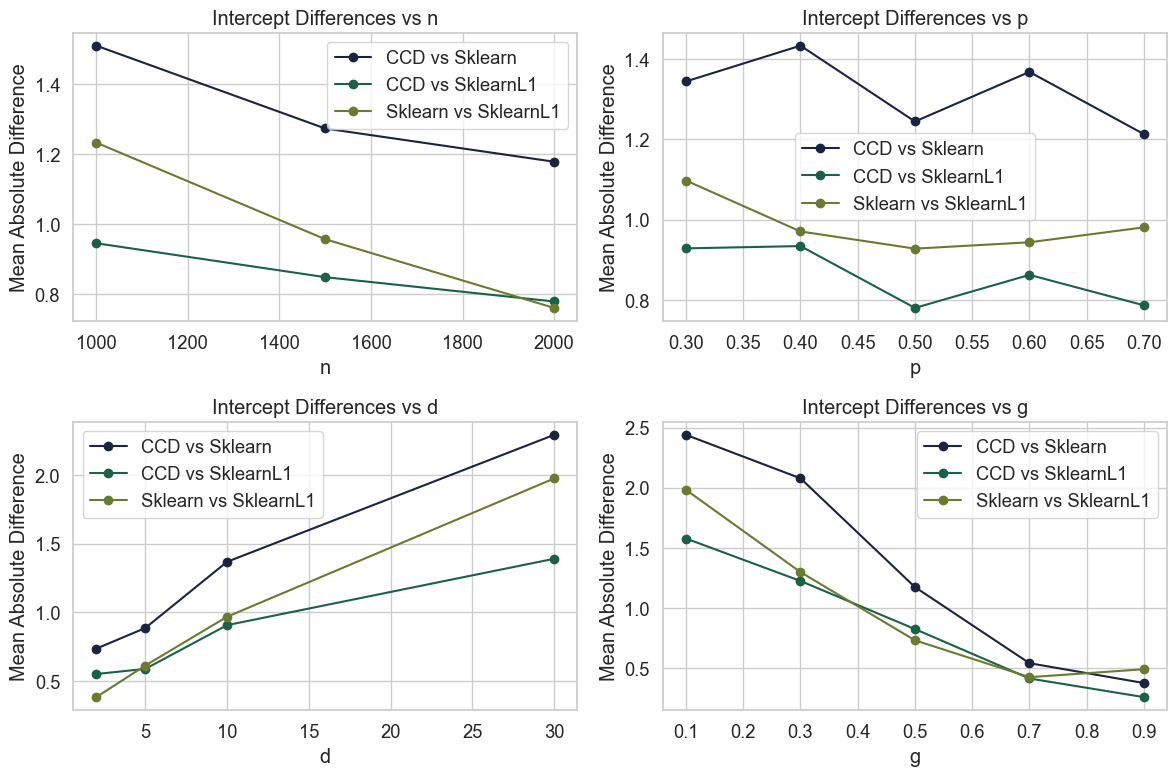

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
parameters = ["n", "p", "d", "g"]

for i, param in enumerate(parameters):
    row = i // 2
    col = i % 2

    mean_diffs = differences_df.groupby(param)[
        [
            "avg_diff_Intercept_CCD_Sklearn",
            "avg_diff_Intercept_CCD_SklearnL1",
            "avg_diff_Intercept_Sklearn_SklearnL1",
        ]
    ].mean()

    mean_diffs.plot(marker="o", ax=axes[row, col])
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel("Mean Absolute Difference")
    axes[row, col].set_title(f"Intercept Differences vs {param}")
    axes[row, col].grid(True)
    axes[row, col].legend(
        ["CCD vs Sklearn", "CCD vs SklearnL1", "Sklearn vs SklearnL1"]
    )

plt.tight_layout()
plt.savefig(
    f"{CONST_RESULTS_DIRECTORY_PATH}/intercept_differences_synthetic_dataset.png"
)

plt.show()

## Discussion about correctness of the LogRegCCD algorithm

### Performance of the algorithm at lambda=0

TODO

In [31]:
def test_logreg_ccd_at_lambda_zero():
    """
    Test LogRegCCD algorithm at lambda=0 and compare with sklearn's LogisticRegression
    without regularization to verify correctness of the implementation.
    """
    np.random.seed(CONST_RANDOM_SEED)
    dataset = SyntheticDataset(p=0.5, n=2000, d=10, g=0.1)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset.X, dataset.y, test_size=0.2, random_state=CONST_RANDOM_SEED
    )

    # Train LogRegCCD with lambda sequence ending at 0
    log_reg_ccd = LogRegCCD()
    lambda_sequence = [0]
    log_reg_ccd.fit(
        X_train,
        y_train,
        regularization_path_lambda_sequence=lambda_sequence,
        maximum_iterations=5000,
        convergance_threshold=1e-07,
    )

    log_reg_sklearn = LogisticRegression(penalty=None, max_iter=5000, tol=1e-07)
    log_reg_sklearn.fit(X_train, y_train)

    lambda_zero_weights = next(
        (w for w in log_reg_ccd.weights if w["lambda"] == 0), None
    )

    if lambda_zero_weights:
        ccd_coefs = lambda_zero_weights["weights"]
        ccd_intercept = lambda_zero_weights["intercept"]
        sklearn_coefs = log_reg_sklearn.coef_[0]
        sklearn_intercept = log_reg_sklearn.intercept_[0]

        print("Comparison of coefficients at lambda=0:")
        coef_df = pd.DataFrame(
            {
                "LogRegCCD": ccd_coefs,
                "LogReg sklearn": sklearn_coefs,
                "Difference": np.abs(ccd_coefs - sklearn_coefs),
            }
        )
        print(coef_df)
        print(
            f"\nMax absolute difference in coefficients: {np.max(np.abs(ccd_coefs - sklearn_coefs))}"
        )

        print(f"\nIntercept comparison:")
        print(f"LogRegCCD: {ccd_intercept}")
        print(f"LogReg sklearn: {sklearn_intercept}")
        print(f"Difference: {abs(ccd_intercept - sklearn_intercept)}")

        ccd_preds = log_reg_ccd.predict(X_test, best_lambda=False)
        sklearn_preds = log_reg_sklearn.predict(X_test)

        print("\nPerformance metrics:")
        metrics = [
            accuracy_score,
            precision,
            recall,
            f1,
            roc_auc_score,
            balanced_accuracy_score,
        ]

        for metric_fn in metrics:
            ccd_score = metric_fn(y_test, ccd_preds)
            sklearn_score = metric_fn(y_test, sklearn_preds)
            print(f"{metric_fn.__name__}:")
            print(f"  LogRegCCD: {ccd_score:.4f}")
            print(f"  LogReg sklearn: {sklearn_score:.4f}")

        plt.figure(figsize=(10, 6))
        x = np.arange(len(ccd_coefs))
        width = 0.35
        plt.bar(x - width / 2, ccd_coefs, width, label="LogRegCCD")
        plt.bar(x + width / 2, sklearn_coefs, width, label="LogReg sklearn")
        plt.xlabel("Feature Index")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Comparison at lambda=0")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.savefig(
            f"{CONST_RESULTS_DIRECTORY_PATH}/logreg_ccd_lambda_zero_comparison.png"
        )

        plt.show()
    else:
        print("No weights found for lambda=0")

    return log_reg_ccd, log_reg_sklearn

Comparison of coefficients at lambda=0:
   LogRegCCD  LogReg sklearn    Difference
0   7.603131        7.603146  1.486571e-05
1   2.814645        2.814638  7.572486e-06
2   2.521183        2.521183  3.957702e-07
3   1.605844        1.605837  7.036259e-06
4   1.159416        1.159413  3.570208e-06
5   0.527428        0.527428  3.855051e-07
6   0.692418        0.692420  1.708954e-06
7   0.937662        0.937659  2.846467e-06
8   0.019703        0.019703  1.556552e-07
9   0.142846        0.142845  1.445769e-06

Max absolute difference in coefficients: 1.4865705105115978e-05

Intercept comparison:
LogRegCCD: -8.798837451626355
LogReg sklearn: -8.79883474219938
Difference: 2.7094269743344057e-06

Performance metrics:
accuracy_score:
  LogRegCCD: 0.7225
  LogReg sklearn: 0.7225
precision:
  LogRegCCD: 0.7207
  LogReg sklearn: 0.7207
recall:
  LogRegCCD: 0.7656
  LogReg sklearn: 0.7656
f1:
  LogRegCCD: 0.7425
  LogReg sklearn: 0.7425
roc_auc_score:
  LogRegCCD: 0.7205
  LogReg sklearn: 0.7205

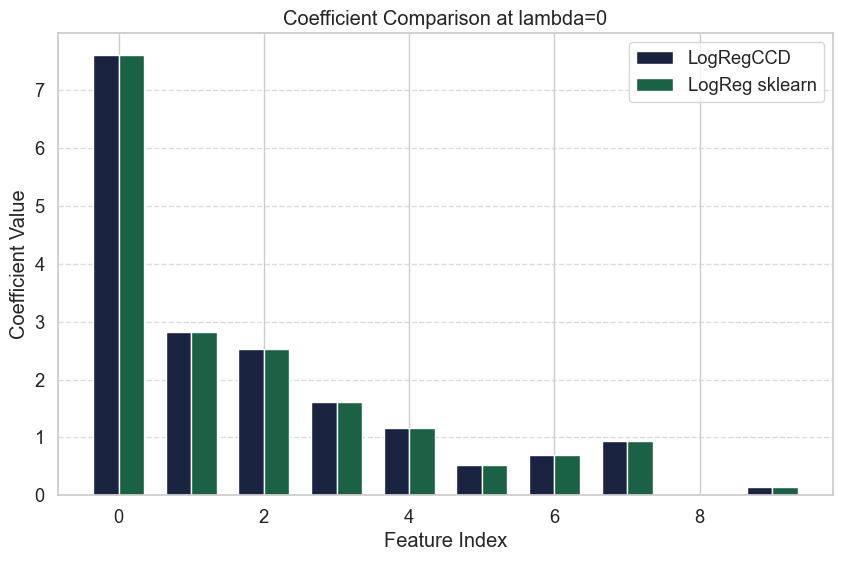

In [32]:
log_reg_ccd, log_reg_sklearn = test_logreg_ccd_at_lambda_zero()

### Likelihood function values and coefficient values depending on iteration

TODO: Iteration of the middle loop or the lambda parameter?

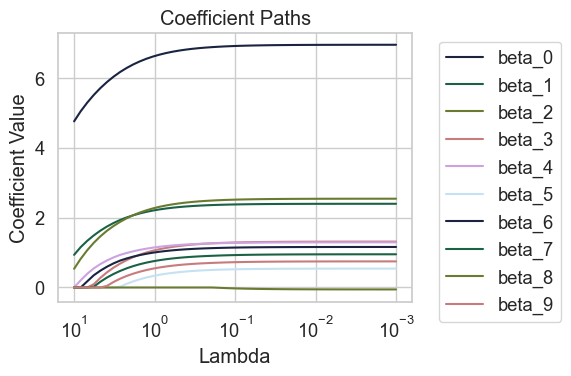

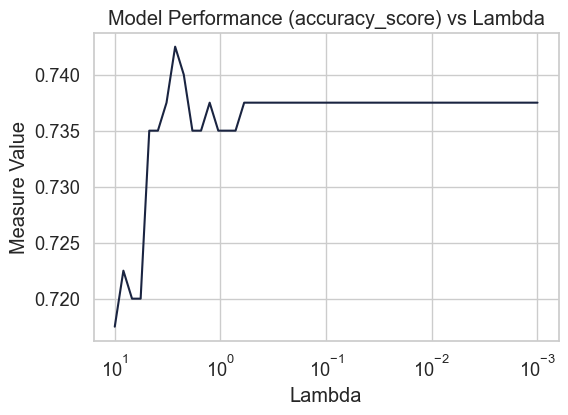

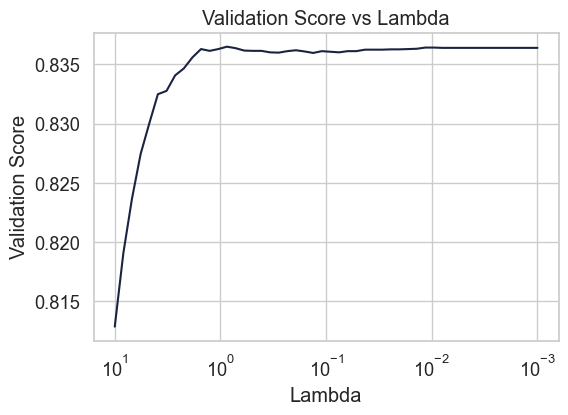

0.735

In [33]:
logRegCCD = LogRegCCD()

test_case = {
    "p": 0.5,
    "n": 2000,
    "d": 10,
    "g": 0.1,
}

data = SyntheticDataset(test_case["p"], test_case["n"], test_case["d"], test_case["g"])

X_train, X_val, y_train, y_val = train_test_split(
    data.X, data.y, test_size=0.4, random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42
)

logRegCCD.fit(X_train, y_train, X_valid=X_val, y_valid=y_val, measure=roc_auc_score)

_ = logRegCCD.plot_coefficients()

_ = logRegCCD.plot(accuracy_score, X_test, y_test)

_ = logRegCCD.plot_validation_scores()

logRegCCD.validate(X_test, y_test, accuracy_score)